In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
train = pd.read_csv('fashion-mnist_train.csv')
train = train.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices({'image':train})

def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images

dataset = dataset.map(preprocess)
dataset = dataset.repeat().shuffle(60000).batch(100).prefetch(1)

In [4]:
input_shape = (28,28,1)
final_encoder_dim = 2
depth = 5
kernel_size = 3
activation = 'tanh'
dropout = 0.1

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def discriminator(input_shape, dim, depth, kernel, dropout,activation):
    layers = []
    layers.append(InputLayer(input_shape=input_shape))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel_size))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(128,activation='relu'))
    layers.append(Dense(dim))
    return Sequential(layers)

encoder = discriminator(input_shape, final_encoder_dim, depth, kernel_size, dropout,activation)

In [6]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0

In [7]:
def generator(input_shape, depth, output_shape,kernel,dropout):
    layers = []
    layers.append(InputLayer(input_shape=(input_shape,)))
    layers.append(Dense(784,activation='relu'))
    layers.append(Reshape(target_shape=output_shape))
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [28,28]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(1,kernel_size=1,activation=None))
    return Sequential(layers)
decoder = generator(final_encoder_dim, depth, input_shape,kernel_size,dropout)

In [8]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)       

In [9]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
encoder_opt = tf.keras.optimizers.Adam()
decoder_opt = tf.keras.optimizers.Adam()

In [10]:

def training(training_data):
    batch_size = tf.shape(training_data)[0]
    real_data = training_data
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    labels = tf.concat((real_labels,fake_labels),axis=0)
    noise = tf.random.normal((batch_size,final_encoder_dim))
    
    with tf.GradientTape() as decoder_gt, tf.GradientTape() as encoder_gt:
        
        fake_images = decoder(noise,training=True)
        fake_labels_2 = encoder(fake_images,training=True)
        real_labels_2 = encoder(training_data,training=True)
        predicted_labels = tf.concat((real_labels_2,fake_labels_2),axis=0)
        

        discrim_loss = loss(labels,predicted_labels)
        #print(discrim_loss)
        gen_loss = loss(real_labels,fake_labels_2)
        
    dec_grad = decoder_gt.gradient(gen_loss,decoder.trainable_variables)
    enc_grad = encoder_gt.gradient(discrim_loss,encoder.trainable_variables)
    
    decoder_opt.apply_gradients(zip(dec_grad, decoder.trainable_variables))
    encoder_opt.apply_gradients(zip(enc_grad, encoder.trainable_variables))
    
    return discrim_loss, gen_loss

In [11]:
import os
def epoch_training(data_iterator, steps_per_epoch, avg_gen_loss, avg_dis_loss):
    for x in range(steps_per_epoch):
        d_loss, g_loss = training(next(data_iterator))
        avg_gen_loss.update_state(g_loss)
        avg_dis_loss.update_state(d_loss)
        if x%20==0:
            print('{} steps done'.format(x))
            
    gen_loss = avg_gen_loss.result()
    dis_loss = avg_dis_loss.result()
    
    
    tf.summary.scalar('gen_loss',gen_loss,step=encoder_opt.iterations)
    tf.summary.flush()
    tf.summary.scalar('dis_loss',dis_loss,step=decoder_opt.iterations)
    tf.summary.flush()
    
    avg_gen_loss.reset_state()
    avg_dis_loss.reset_state()
    return gen_loss.numpy(), dis_loss.numpy()
    
def train(training_data, epochs):
    

    
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=decoder_opt,discriminator_optimizer=encoder_opt,generator=decoder,discriminator=encoder)
    manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint)
    
    summary = tf.summary.create_file_writer('metrics/train')
    
    avg_generator_loss = tf.keras.metrics.Mean()
    avg_discriminator_loss = tf.keras.metrics.Mean()
    
    data_iterator = training_data.__iter__()
    for i in range(epochs):
        with summary.as_default():
            gen_loss, dis_loss = epoch_training(data_iterator, 600, avg_generator_loss, avg_discriminator_loss)
            print({'gen_loss':gen_loss,'dis_loss':dis_loss})
            manager.save()


In [12]:
train(dataset,10)

0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
100 steps done
120 steps done
140 steps done
160 steps done
180 steps done
200 steps done
220 steps done
240 steps done
260 steps done
280 steps done
300 steps done
320 steps done
340 steps done
360 steps done
380 steps done
400 steps done
420 steps done
440 steps done
460 steps done
480 steps done
500 steps done
520 steps done
540 steps done
560 steps done
580 steps done
{'gen_loss': 5.1994023, 'dis_loss': 0.14459148}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
100 steps done
120 steps done
140 steps done
160 steps done
180 steps done
200 steps done
220 steps done
240 steps done
260 steps done
280 steps done
300 steps done
320 steps done
340 steps done
360 steps done
380 steps done
400 steps done
420 steps done
440 steps done
460 steps done
480 steps done
500 steps done
520 steps done
540 steps done
560 steps done
580 steps done
{'gen_loss': 7.0065413, 'dis_loss': 0.05855007}
0 steps done
20 

KeyboardInterrupt: 

In [29]:
noise = tf.random.normal([1,2])
images = decoder(noise,training=False)

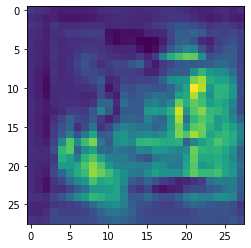

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
for x in images:
    plt.imshow(x)

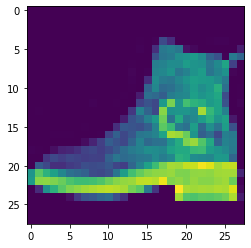

In [20]:
count =0
for x in dataset:
    
    plt.imshow(x[1])
    if count==5:
        break
    count+=1

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint